# CNN Klasyfikujący obrazy płuc


In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd




In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/lung-cancer-histopathological-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1


Utworzenie scieżki do danych

In [23]:
dataset_path = "/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1"

Utworzenie zmiennch koniecznych do podziału danych przy pomocy funkcji z biblioteki keras

In [24]:
batch_size = 64
img_height = 128
img_width = 128

Dzielenie danych na grupy trenujące i walidacyjne

In [25]:
train_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.


In [26]:
val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


### Prefetching danych

Aby poprawić wydajność procesu uczenia, używam funkcji `prefetch`, która umożliwia wstępne ładowanie danych w tle, podczas gdy model jest trenowany na obecnej partii danych.

- `tf.data.AUTOTUNE` pozwala TensorFlow dynamicznie dostosować liczbę wątków do optymalnego ładowania danych.
- Użycie `prefetch` pomaga uniknąć "czekania" na dane i umożliwia równoczesne ładowanie nowych danych podczas trenowania modelu, co skraca czas potrzebny na trenowanie.

In [27]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Przykładowe dane
Zdjęcia przedstawiają 3 kategorie:
- Gruczolakorak
- Zdrowe płuca
- Rak kolczystokomórkowy

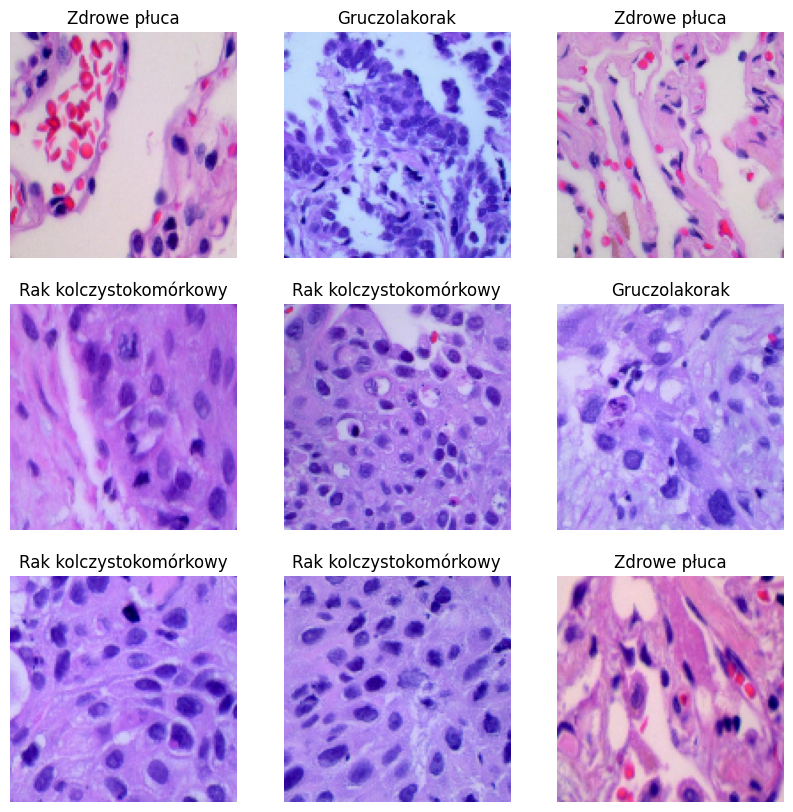

In [28]:
labels = ["Gruczolakorak", "Zdrowe płuca", "Rak kolczystokomórkowy"]


plt.figure(figsize=(10,10))
for images, num_labels in train_ds.take(1):
    for x in range(9):
        ax = plt.subplot(3, 3, x+1)
        plt.imshow(np.array(images[x]).astype('uint8'))
        label_text = labels[int(num_labels[x])]
        plt.title(label_text)
        plt.axis('off')

### Tworzenie modelu CNN (Convolutional Neural Network)

W tej komórce tworzony jest model sieci konwolucyjnej (CNN) do klasyfikacji obrazów. Model składa się z kilku warstw konwolucyjnych i max pooling, a także kilku warstw gęstych (fully connected), aby przewidywać klasy na podstawie obrazów.

1. **Wejście do modelu**:
   - `keras.Input(shape=(128, 128, 3))` określa kształt obrazu wejściowego, który będzie miał wymiary 128x128 pikseli oraz 3 kanały (RGB).

2. **Warstwa augmentacji (RandomRotation)**:
   - `layers.RandomRotation(0.1)` wprowadza losową rotację obrazów o maksymalnie 10%, co pomaga w poprawie generalizacji modelu.

3. **Reskalowanie obrazów**:
   - `layers.Rescaling(scale=1./255)` normalizuje obrazy, dzieląc wartości pikseli przez 255, aby przekształcić je na zakres [0, 1].

4. **Warstwy konwolucyjne (Conv2D)**:
   - Pierwsza warstwa konwolucyjna (`layers.Conv2D`) posiada 32 filtry o rozmiarze 3x3 oraz funkcję aktywacji ReLU. Zastosowano `padding="same"`, co oznacza, że obraz wyjściowy ma takie same wymiary jak wejściowy.
   - Kolejna warstwa konwolucyjna z 64 filtrami o rozmiarze 3x3 również z paddingiem "same".

5. **Warstwy max pooling (MaxPooling2D)**:
   - Warstwy `layers.MaxPooling2D(pool_size=(2, 2))` stosują pooling z rozmiarem okna 2x2, zmniejszając wymiary obrazów i zachowując tylko najważniejsze cechy.

6. **Flatten**:
   - `layers.Flatten()` spłaszcza wyjście z warstw konwolucyjnych i poolingowych do jednowymiarowego wektora, który może zostać podany do warstwy gęstej.

7. **Warstwy gęste (Dense)**:
   - Pierwsza warstwa gęsta (`layers.Dense(64, activation="relu")`) ma 64 jednostki i stosuje funkcję aktywacji ReLU.
   - Druga warstwa gęsta (`layers.Dense(3, activation="softmax")`) posiada 3 jednostki, odpowiadające 3 klasom, i stosuje funkcję aktywacji Softmax, aby uzyskać prawdopodobieństwa dla każdej z klas.

8. **Kompilacja modelu**:
   - Model jest kompilowany z optymalizatorem `adam` i funkcją straty `sparse_categorical_crossentropy`, ponieważ jest to problem klasyfikacji wieloklasowej. Zastosowano również metrykę dokładności (`accuracy`).



In [29]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

model.add(keras.Input(shape=(128, 128, 3)))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomZoom(0.1))
model.add(layers.RandomBrightness(0.1))
model.add(layers.Rescaling(scale=1./255))


model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (5, 5), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation="softmax"))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


### Użycie Callback'u: `EarlyStopping`

W tej komórce kodu tworzę obiekt callback, który będzie wykorzystywany w trakcie treningu modelu:

**`EarlyStopping`**:
   - Callback `EarlyStopping` jest wykorzystywany do monitorowania postępów modelu w trakcie treningu, w celu przerwania treningu, gdy model przestaje się poprawiać.
   - Parametry:
     - `monitor='val_accuracy'`: Monitoruje dokładność na zbiorze walidacyjnym (nie na treningowym).
     - `patience=5`: Określa liczbę epok, w których model nie może poprawić swojej dokładności na zbiorze walidacyjnym, zanim trening zostanie przerwany. W tym przypadku po 5 epokach bez poprawy zatrzymamy trening.
     - `restore_best_weights=True`: Po przerwaniu treningu, model zostanie przywrócony do stanu, w którym osiągnął najlepszy wynik na zbiorze walidacyjnym (nawet jeśli później dokładność zacznie maleć).
   
Dzięki temu, mogę monitorować efektywność modelu i przerwać trening, jeśli dalsze trenowanie nie poprawia wyników.


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='my_model.keras',
    monitor='val_accuracy',
    save_best_only=True,  # Zapisuje tylko najlepszy model
    mode='max',
    verbose=1  # Wypisuje informacje o zapisie modelu
)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)


# Wizualizacja wyników treningu modelu

Poniższy kod przedstawia wykresy pokazujące dokładność oraz stratę modelu w trakcie treningu i walidacji w zależności od liczby epok.


Epoch 1/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7452 - loss: 0.5352
Epoch 1: val_accuracy improved from -inf to 0.77467, saving model to my_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 209ms/step - accuracy: 0.7457 - loss: 0.5345 - val_accuracy: 0.7747 - val_loss: 0.4984
Epoch 2/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8783 - loss: 0.2966
Epoch 2: val_accuracy improved from 0.77467 to 0.90600, saving model to my_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.8783 - loss: 0.2965 - val_accuracy: 0.9060 - val_loss: 0.2328
Epoch 3/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9082 - loss: 0.2306
Epoch 3: val_accuracy improved from 0.90600 to 0.91533, saving model to my_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - accuracy: 0.9082 - loss: 0.2306 - val_accuracy: 0.9153 - val_loss: 0.1922
Epoch 4/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9182 - loss: 0.2070
Epoch 4: val_accuracy did not 

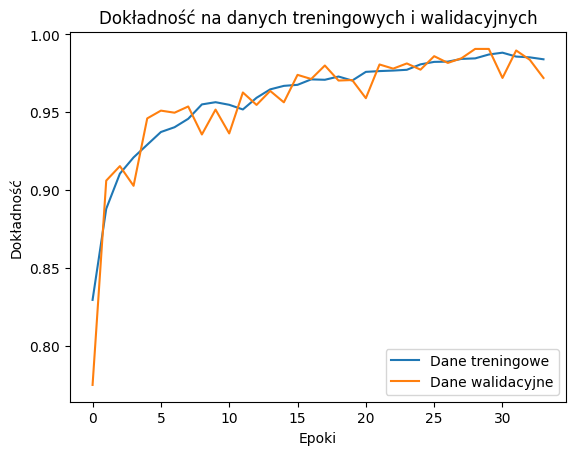

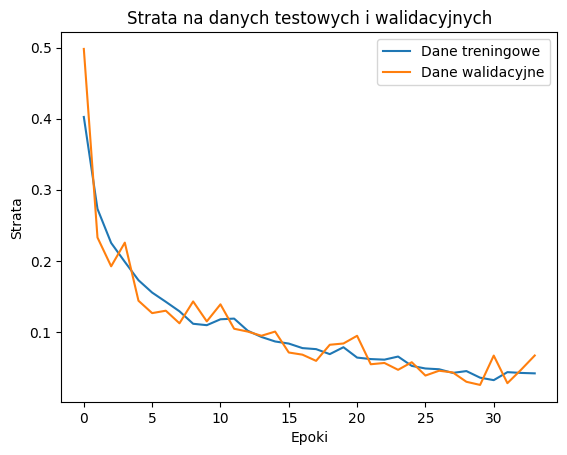

In [31]:
import matplotlib.pyplot as plt
history = model.fit(train_ds, epochs=64, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])



train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, label='Dane treningowe')
plt.plot(val_acc, label='Dane walidacyjne')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.title('Dokładność na danych treningowych i walidacyjnych')
plt.legend(loc='lower right')
plt.show()

plt.plot(train_loss, label='Dane treningowe')
plt.plot(val_loss, label='Dane walidacyjne')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.title('Strata na danych testowych i walidacyjnych')
plt.legend(loc='upper right')
plt.show()

## Confusion matrix



In [32]:
y_true = []  # Prawdziwe etykiety
y_pred = []  # Przewidywania modelu


for images, labels in val_ds:
    y_true.extend(labels.numpy())

    predictions = model.predict(images)  # Predykcje modelu dla danej partii obrazów

    predicted_labels = np.argmax(predictions, axis=1)  # Przewidywana klasa (z indeksu o najwyższym prawdopodobieństwie)

    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Prawdziwe etykiety:", y_true[:10])
print("Predykcje modelu:", y_pred[:10])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)

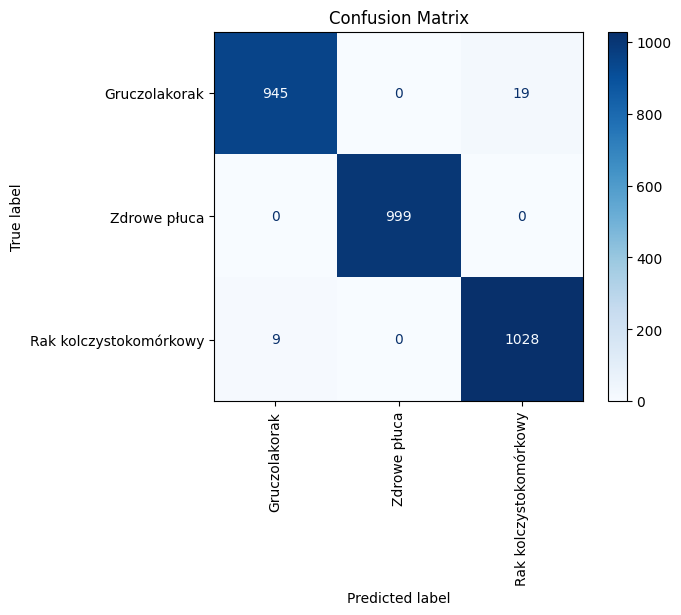

In [34]:
labels = ["Gruczolakorak", "Zdrowe płuca", "Rak kolczystokomórkowy"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) #Macierz pomyłek
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()

Macierz błędu pokazuje, że model miał najwiekszy problem z rozróżnianiem gruczkolakoraka i raka kolczystokomórkowego

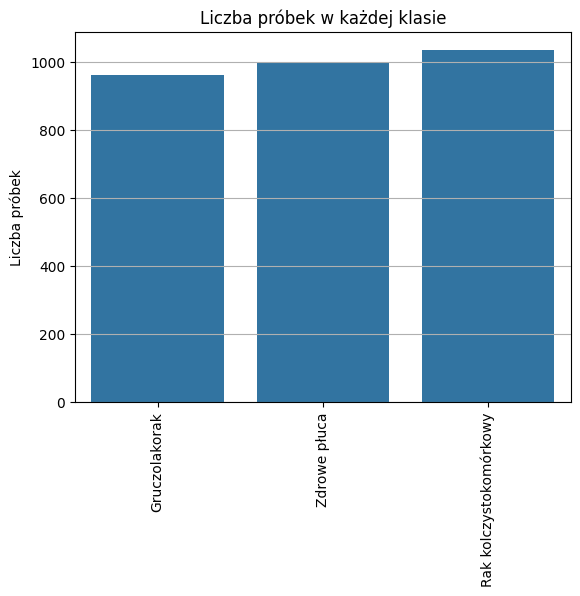

In [35]:
labels = []
for images, label_batch in val_ds:
    labels.extend(label_batch.numpy())

labels = np.array(labels)

true_labels = ["Gruczolakorak", "Zdrowe płuca", "Rak kolczystokomórkowy"]
sns.countplot(x=labels) # Wykres słupkowy z liczbą próbek dla każdej klasy
plt.title('Liczba próbek w każdej klasie')

plt.xticks(ticks=np.arange(len(true_labels)), labels=true_labels, rotation=90)
plt.ylabel('Liczba próbek')
plt.grid(axis='y')
plt.show()

In [36]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

## Model pretrenowany `VGG16`

In [37]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Zamrożenie wag w warstwach pretrenowanych, aby nie były aktualizowane podczas treningu
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Nowy model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Kompilacja modelu
model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
history_vgg16 = model_vgg16.fit(train_ds, epochs=64, validation_data=val_ds, callbacks=early_stopping)

Epoch 1/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 273ms/step - accuracy: 0.8905 - loss: 0.8727 - val_accuracy: 0.9610 - val_loss: 0.1216
Epoch 2/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 190ms/step - accuracy: 0.9762 - loss: 0.0667 - val_accuracy: 0.9697 - val_loss: 0.0930
Epoch 3/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.9874 - loss: 0.0359 - val_accuracy: 0.9713 - val_loss: 0.0888
Epoch 4/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 207ms/step - accuracy: 0.9920 - loss: 0.0195 - val_accuracy: 0.9707 - val_loss: 0.0913
Epoch 5/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - accuracy: 0.9917 - loss: 0.0371 - val_accuracy: 0.9680 - val_loss: 0.1401
Epoch 6/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - accuracy: 0.9823 - loss: 0.0695 - val_accuracy: 0.9743 - val_loss: 0.1023
Epoch 7/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.9933 - loss: 0.0180 - val_accuracy: 0.9753 - val_loss: 0.0975
Epoch 8/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 207ms/step - accuracy: 0.9978 - loss: 0

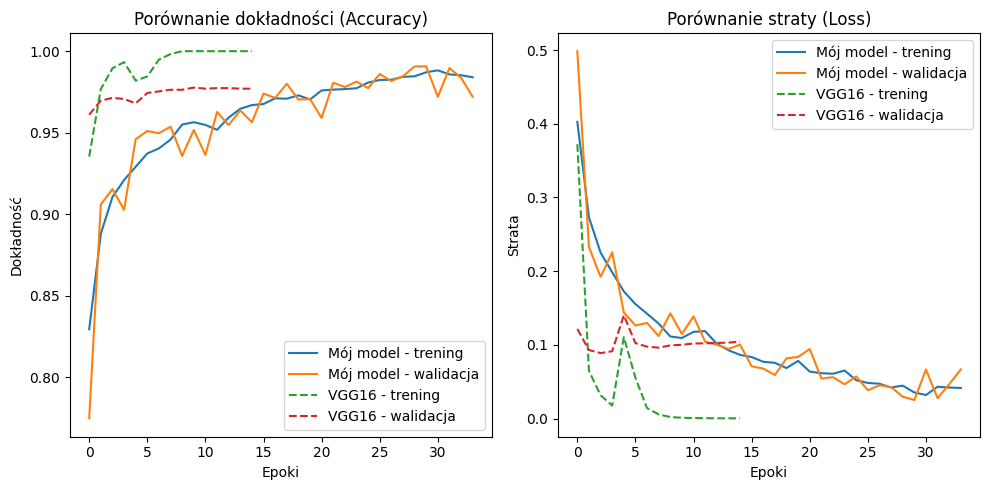

In [39]:
# Wykres porównujący dokładność mojego modelu z VGG16
train_acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']
train_acc_my_model = history.history['accuracy']
val_acc_my_model = history.history['val_accuracy']

plt.figure(figsize=(10, 5))

# Dokładność
plt.subplot(1, 2, 1)
plt.plot(train_acc_my_model, label='Mój model - trening')
plt.plot(val_acc_my_model, label='Mój model - walidacja')
plt.plot(train_acc_vgg16, label='VGG16 - trening', linestyle='--')
plt.plot(val_acc_vgg16, label='VGG16 - walidacja', linestyle='--')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.title('Porównanie dokładności (Accuracy)')
plt.legend()

# Strata
train_loss_my_model = history.history['loss']
val_loss_my_model = history.history['val_loss']
train_loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(train_loss_my_model, label='Mój model - trening')
plt.plot(val_loss_my_model, label='Mój model - walidacja')
plt.plot(train_loss_vgg16, label='VGG16 - trening', linestyle='--')
plt.plot(val_loss_vgg16, label='VGG16 - walidacja', linestyle='--')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.title('Porównanie straty (Loss)')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
print(f"Dokładność mojego modelu na zbiorze walidacyjnym: {val_acc_my_model[-1]:.4f}")
print(f"Dokładność modelu VGG16 na zbiorze walidacyjnym: {val_acc_vgg16[-1]:.4f}")


Dokładność mojego modelu na zbiorze walidacyjnym: 0.9720
Dokładność modelu VGG16 na zbiorze walidacyjnym: 0.9770
